## Assignment #4. Combinatorial optimization with Gurobi
20200045 Kimgeonwoo
- Task 1 : TSP
    - task 1-1. preparing data
    - task 1-2. visualizing data and solution 
    - task 1-3. solving standard TSP
    - task 1-4. solving TSP with specified start and end
    - task 1-5. finding the shortest open tour
    
- Task 2 : Hospital location selection
    - task 2-1. hospical location selection to minimize distance from households
        - assignment problem (minimizing assigment cost)
        - combined with knapsack problem (selection within budget limit)
    - task 2-2. solving large population case
        - k-means clustering
        - apply the above

### Task 1. Solving TSP with Gurobi
- Miller–Tucker–Zemlin (MTZ) formulation
- problem data
    - $J = \{0, 1, ..., N-1\}$ : set of cities to visit
    - $D$ : distance $N \times N$, symmetric matrix
        * $D_{ij}$ : distance from $i$ to $j$
- decision variables
    - $x_{ij}$ : binary decision var
        * $x_{ij} = 1$ : travel from $i$ to $j$ in the solution
- objective function
    * $\min \sum_{i,j \in J}{D_{ij}x_{ij}}$
        * m.setObjective(gp.quicksum(x[i,j]*D[i,j] for j in range(N) for i in range(N)), GRB.MINIMIZE)
- constraints
    * $x_{ii}=0, \forall i \in J$ : no self-connection
    * $\sum_{i}{x_{ij}}=1, \forall j \in J$ : unique incoming edge
    * $\sum_{j}{x_{ij}}=1, \forall i \in J$ : unique outgoing edge
- preventing sub-tours
    * with the above constraints, disconnected subtours are possible
    * more variables and constraints are introduced
    * $u_i$ : __order of arrival__ at city $i$
        * $0 \leq u_i \leq N-1$ : continuous variable in $[0,N-1]$
        * $u_0 = 0$ : fix start city as $0$
    * $u_j \geq u_i + 1 - 2N(1-x_{ij}), \forall i,j \in J, j \ne 0 $
        * if $x_{i,j}=0$, $u_j \geq u_i + 1 - 2N$ : this constraint is redundant (meaningless) 
        * if $x_{i,j}=1$, $u_j \geq u_i + 1$ : actually $u_j = u_i + 1$ if $x_{i,j}=1$  
- alternative way of preventing sub-tours 
    * $u_i$ : __time of arrival__ at city $i$,  $u_i \geq 0$ : continuous variable
        * $u_0 = 0$ : fix start city as $0$
    * $u_j \geq u_i + D_{ij} - M(1-x_{ij}), \forall i,j \in J, j \ne 0 $
        * if $x_{i,j}=0$, $u_j \geq u_i + D_{ij} - M$ : this constraint is redundant (meaningless) 
        * if $x_{i,j}=1$, $u_j \geq u_i + D_{ij}$ : actually $u_j = u_i + D_{ij}$ if $x_{i,j}=1$  
        * $M$ : a big number, e.g. $M = N \times \max{D_{ij}}$

#### Task 1-1. Prepare data
```python
def prepare_tsp_data(filename):
    ...
    return ct, D
```
- complete the above function in the following cell, which
    * reads data from 'usa35.csv' file as a pd.DataFrame    
        * contains 3 columns : id, x, y for each city (N=35)
    * computes pairwise Euclidean distance between cities
        * you may use numpy broadcasting or scipy.spatial.distance
        * please refer k-nearest neighbors example at the end of lecture note on numpy (Chap.2)
    * then, returns
        * ct : DataFrame containing the file
        * D : distance matrix (N x N)

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import pdist, squareform
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
# Task 1-1.  Complete the following function to read data and compute the distance matrix


def prepare_tsp_data(filename):
    ct = pd.read_csv('/content/drive/MyDrive/20200045/'+filename)
    N = len(ct)
    D = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            D[i][j] = ((ct['x'][i]-ct['x'][j])**2+(ct['y'][i]-ct['y'][j])**2)**0.5
    return ct, D

ct1, D1 = prepare_tsp_data('usa35.csv')
D1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array([[   0.        , 4726.65314996, 1204.34920185, ..., 1747.35915026,
        2141.2381932 , 6754.23496778],
       [4726.65314996,    0.        , 3587.42316991, ..., 5252.22029241,
        2655.55436774, 3122.58482671],
       [1204.34920185, 3587.42316991,    0.        , ..., 1965.15063036,
         949.29447486, 5563.66003634],
       ...,
       [1747.35915026, 5252.22029241, 1965.15063036, ...,    0.        ,
        2684.35262214, 6474.12217988],
       [2141.2381932 , 2655.55436774,  949.29447486, ..., 2684.35262214,
           0.        , 4696.65295716],
       [6754.23496778, 3122.58482671, 5563.66003634, ..., 6474.12217988,
        4696.65295716,    0.        ]])

### Task 1-2. Plot data and tour
```python
def plot_tour(ct, tour=None, open_tour=False):
    ...
```
- complete the above function in the following cell, which
    * plots cities in ct
    * plots tour (skip if tour=None)
        * if open_tour == True, there is no returning edge (from ending to starting city)
        * if not, do not forget to connect the last city to the starting city (in red)
    * as shown below
        * tour = None 
            * ![image.png](attachment:95666eb0-568b-453a-89f9-6efc8c77296c.png)
        * tour is given
            * ![image.png](attachment:959875e9-6b05-467e-a46f-4cc0ae405e8a.png)

In [165]:
from pandas.core.arrays.numeric import T
# Task 1-2.  Complete the following function to plot cities and tour
def plot_tour(ct, tour=None, open_tour=False):
    plt.scatter(ct['x'],ct['y'])

    if tour != None: # path is given
        tour_x = []
        tour_y = []
        for i in tour:
            tour_x.append(ct['x'][i])
            tour_y.append(ct['y'][i])
        plt.plot(tour_x,tour_y,color = 'black')

        if open_tour == False:    
            if (tour_x[0] != tour_x[-1]) & (tour_y[0] != tour_y[-1]): # no returning edge
                atour_x = []
                atour_y = []
                atour_x.append(ct['x'][tour[-1]])
                atour_y.append(ct['y'][tour[-1]])
                atour_x.append(ct['x'][tour[0]])
                atour_y.append(ct['y'][tour[0]])
                plt.plot(atour_x,atour_y,color = 'red') #in red
    

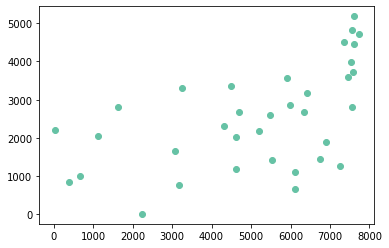

In [347]:
ct, D = prepare_tsp_data('usa35.csv')  # opt. sol = 27560.58
plot_tour(ct)

### Task 1-3. Implement TSP (MTZ formulation) in Gurobi
```python
def solve_tsp(ct, D):
    ...
```
- complete the above function in the following cell, which
    * takes ct and D as input
        - ct : DataFrame of city locations
        - D : pairwise distance numpy matrix
    * implements MTZ formulation of TSP
        - make model
        - add decision variable
        - add constraints
        - set objective
        - solve
    * print the length of the tour found
        - objective value
    * plots tour
        - get the order of cities in the tour found
            * make a list from u[i].x
            * use np.argsort to get the tour order
        - use plot_tour function above

In [167]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1296 rows, 1260 columns and 5988 nonzeros
Model fingerprint: 0x5ff8a603
Variable types: 0 continuous, 1260 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [2e+02, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 70 rows and 36 columns
Presolve time: 0.08s
Presolved: 1226 rows, 1224 columns, 5814 nonzeros
Variable types: 0 continuous, 1224 integer (1190 binary)

Root relaxation: objective 2.377436e+04, 120 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 23774.3551    0   70          - 23774.3551      -     -

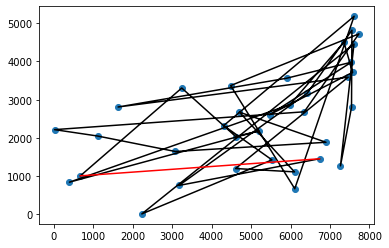

In [168]:
import gurobipy as gp
from gurobipy import GRB

# Task 1-3. Miller–Tucker–Zemlin formulation
def solve_tsp(ct, D):
    try:
        # make model
        m = gp.Model("TSP_model")
        N = len(ct)

        #var
        x = m.addMVar(shape = (N,N), vtype = GRB.BINARY, name="x")
        u = m.addMVar(shape = N, vtype = GRB.INTEGER, name='order')
        #objective func
        m.setObjective(gp.quicksum(x[i,j]*D[i,j] for j in range(N) for i in range(N)),GRB.MINIMIZE)
        #constraints
        for i in range(N):
            m.addConstr(x[i][i]==0, name = 'no self-connection')
            m.addConstr(x[i,:].sum()==1, name = 'unique outgoing edge')
            m.addConstr(x[:,i].sum()==1, name = 'unique incoming edge')

        #preventing sub-tours
        m.addConstr(u[0]==0, name = 'fix start')
        for i in range(N):
            for j in range(N):
                if (j!=0):
                    m.addConstr(u[j]>=u[i]+1-2*N*(1-x[i][j]), name = 'order of arrival')
        #optimize model
        m.optimize()

        tour_len = m.objVal

        print(f"sum of length of the tour = {tour_len}")
        print("x=",x)
        print("u=",u)

        tour = []
        for i in range(N):
            tour.append(u[i].x)
        plot_tour(ct,tour)



    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))
        
solve_tsp(ct, D);

### Task 1-4. Modification of TSP : starting and ending cities are given
```python
def solve_tsp_se(ct, D, s=-1, e=-1):
    ...
```
- complete the above function in the following cell, which
    * takes the following inputs
        - ct : DataFrame of city locations
        - D : pairwise distance numpy matrix
        - s : starting city index (default=-1 : starting city is not specified)
        - e : ending city index (default=-1 : ending city is not specified)
        * both s<0 and e<0 : same as the original TSP
- expected output  
    ![image.png](attachment:66eef17f-9cce-451c-9c71-e18b5cfef8d4.png)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1298 rows, 1260 columns and 5990 nonzeros
Model fingerprint: 0x112aa908
Variable types: 0 continuous, 1260 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [2e+02, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 108 rows and 104 columns
Presolve time: 0.04s
Presolved: 1190 rows, 1156 columns, 5546 nonzeros
Variable types: 0 continuous, 1156 integer (1123 binary)

Root relaxation: objective 2.812550e+04, 116 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 28125.5036    0   44          - 28125.5036      -    

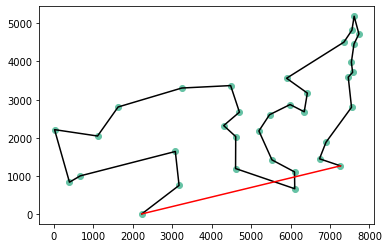

In [348]:
# Task 1-4. TSP with Start and/or End city 
def solve_tsp_se(ct, D, s=-1, e=-1, plot=True):
    try: 
        
        # make model
        m = gp.Model("TSP_model_with_Start_End")
        N = len(ct)

        #var
        x = m.addMVar(shape = (N,N), vtype = GRB.BINARY, name="x")
        u = m.addMVar(shape = N, vtype = GRB.INTEGER, name='order')
        #objective func
        m.setObjective(gp.quicksum(x[i,j]*D[i,j] for j in range(N) for i in range(N)),GRB.MINIMIZE)
        #constraints
        for i in range(N):
            m.addConstr(x[i][i]==0, name = 'no self-connection')
            m.addConstr(x[i,:].sum()==1, name = 'unique outgoing edge')
            m.addConstr(x[:,i].sum()==1, name = 'unique incoming edge')
        if (s>=0) & (e>=0):
            m.addConstr(x[e][s]==1, name = 'End')
        #preventing sub-tours
        if s<0:
            m.addConstr(u[0]==0, name = 'fix start')
            if e<0:
                for i in range(N):
                    for j in range(N):
                        if (j!=0):
                            m.addConstr(u[j]>=u[i]+1-2*N*(1-x[i][j]), name = 'order of arrival')
            else: #e>=0:
                #m.addConstr(u[e]==N-1, name = 'with End')
                for i in range(N):
                    for j in range(N):
                        if (j!=0):
                            m.addConstr(u[j]>=u[i]+1-2*N*(1-x[i][j]), name = 'order of arrival')
        else: #s>=0:
            #m.addConstr(u[0]==0, name = 'fix start')
            m.addConstr(u[s]==0, name = 'with Start')
            if e<0:
                for i in range(N):
                    for j in range(N):
                        if (j!=s):
                            m.addConstr(u[j]>=u[i]+1-2*N*(1-x[i][j]), name = 'order of arrival')
            else: #e>=0:
                m.addConstr(u[e]==N-1, name = 'with End')
                #m.addConstr(x[e][s]==1, name = 'End')
                for i in range(N):
                    for j in range(N):
                        if (j!=s):
                            m.addConstr(u[j]>=u[i]+1.0-2*N*(1-x[i][j]), name = 'order of arrival')
                            #m.addConstr(u[j]<=u[e], name = 'with End')
        
        
        #optimize model
        m.optimize()

        tour_len = m.objVal

        print(f"sum of length of the tour = {tour_len}")
        print("x=",x)
        print("u=",u)

               
        tour1 = []
        for i in range(N):
            tour1.append(int(u[i].x))
        tour2 = np.argsort(tour1)
        tour3 = []
        for i in range(N):
            tour3.append(tour2[i])     
        plot_tour(ct,tour3,)
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))
        
        
solve_tsp_se(ct, D, 1, 7);

### Task 1-5. Modification of TSP : find shortest open tour
```python
def solve_tsp_open(ct, D):
    ...
```
- complete the above function in the following cell, which finds minimum length open tour
    * note that no returning edge is required
    * expected output : length = 25516.585
    ![image.png](attachment:a997b0e4-b929-4c41-80bb-1d686e010df1.png)
- hint: 
    - introduce a dummy city connecting all other cities with 0 length edge
    - solve TSP with modified graph
    - remove 2 edges connecting the dummy node from the tour
    - then we get shorted open tour
    ![image.png](attachment:63802b9e-4e5e-4f89-9fd8-371f22812738.png)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1369 rows, 1332 columns and 6339 nonzeros
Model fingerprint: 0xee3ab2d3
Variable types: 0 continuous, 1332 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [2e+02, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 72 rows and 37 columns
Presolve time: 0.03s
Presolved: 1297 rows, 1295 columns, 6160 nonzeros
Variable types: 0 continuous, 1295 integer (1260 binary)

Root relaxation: objective 2.162649e+04, 311 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 21626.4872    0   71          - 21626.4872      -     -

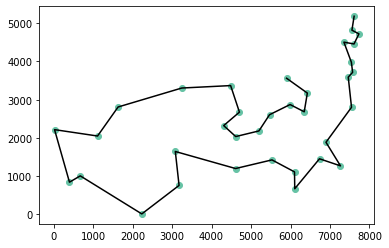

In [349]:
# Task 1-5. TSP with open tour 
def solve_tsp_open(ct, D):
    try: 
        # make model
        m = gp.Model("TSP_model_open")
        N = len(ct)

        D = np.zeros((N+1,N+1))
        for i in range(N+1):
            for j in range(N+1):
                if i==N or j==N:
                    D[i][j] = 0;
                else:
                    D[i][j] = ((ct['x'][i]-ct['x'][j])**2+(ct['y'][i]-ct['y'][j])**2)**0.5

        #var
        x = m.addMVar(shape = (N+1,N+1), vtype = GRB.BINARY, name="x")
        u = m.addMVar(shape = N+1, vtype = GRB.INTEGER, name='order')
        #objective func
        m.setObjective(gp.quicksum(x[i,j]*D[i,j] for j in range(N+1) for i in range(N+1)),GRB.MINIMIZE)
        #constraints
        for i in range(N+1):
            m.addConstr(x[i][i]==0, name = 'no self-connection')
            m.addConstr(x[i,:].sum()==1, name = 'unique outgoing edge')
            m.addConstr(x[:,i].sum()==1, name = 'unique incoming edge')

        #preventing sub-tours
        m.addConstr(u[0]==0, name = 'fix start')
        for i in range(N+1):
            for j in range(N+1):
                if (j!=0):
                    m.addConstr(u[j]>=u[i]+1-2*N*(1-x[i][j]), name = 'order of arrival')
        #optimize model
        m.optimize()

        tour_len = m.objVal

        print(f"sum of length of the tour = {tour_len}")
        print("x=",x)
        print("u=",u)
        
        
        
        tour1 = []
        for i in range(N+1):
            tour1.append(int(u[i].x))
        tour2 = np.argsort(tour1)
        tour3 = []
        for i in range(N+1):
            tour3.append(tour2[i])     
        M = max(tour3)
        for i in range(N+1):
            if tour3[i] == M:
                tour4_1 = tour3[0:i]
                tour4_2 = tour3[i+1:]
        tour4 = tour4_2 + tour4_1
        
        plot_tour(ct,tour4,open_tour=True)
        
        
        
    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))
        
        
solve_tsp_open(ct, D)

## Task 2. Hospital location selection
![image.png](attachment:dd353934-9886-4a17-8164-fd23fd1201c7.png)

#### Formulation as an IP

![image.png](attachment:2d8f2412-3b2b-4a15-8ec6-a974b29d9fab.png)
<br>
<br>
<br>

### Preliminary
- generate data
    - generate_population : household population (household size = 1)
    - generate_locations : hospical candidate locations and their costs
- plot_result
    - plot household location (red)
        - popi : individual population (to be used later)
        - popg : household 
    - plot candidate location (green)
    - plot assignment if given (black)
- initially, 1000 households and 100 locations are generated

In [337]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import pdist, squareform
import numpy as np

In [338]:
def generate_population(N_pop, N_cen=5):
    n = N_pop // N_cen
    cen = np.random.random((N_cen, 2))
    sigma = 0.1
    for i in range(N_cen):
        if i == N_cen-1:
            n = N_pop - n*i
        pop_i = cen[i,:] + sigma*np.random.randn(n,2)
        if i == 0: 
            pop = pop_i
        else:
            pop = np.append(pop, pop_i, axis=0)
    return pop

def generate_locations(N_loc, pop):
    min = pop.min(axis=0)
    max = pop.max(axis=0)
    d = max - min
    loc = np.random.random((N_loc, 2))
    loc = min + d * loc
    cost = 100 + np.random.random(N_loc) * 100
    return loc, cost

In [339]:
def plot_result(popi=None, popg=None, loc=None, x=None):
    plt.figure(figsize=(8,8), dpi=80)
    if popi is not None:
        plt.scatter(*zip(*popi), c='Pink', s=0.5)
    if popg is not None:
        plt.scatter(*zip(*popg), c='Red', s=10)
    if loc is not None:
        plt.scatter(*zip(*loc), c='Green', s=10)
    if x is not None:
        for p in range(popg.shape[0]):
            for h in range(loc.shape[0]):
                if x[h,p].x > 0.5:
                    pts = [loc[h], popg[p]]
                    plt.plot(*zip(*pts), c='Black', linewidth=0.1)

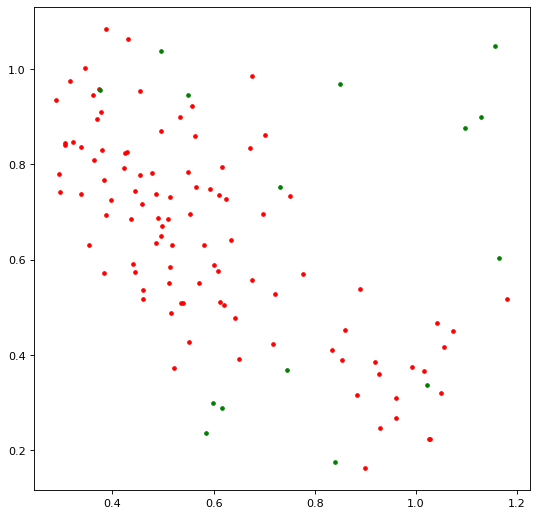

In [340]:
np.random.seed(0)
pop = generate_population(100)
loc, cost = generate_locations(15, pop)
budget = 500
plot_result(popg=pop, loc=loc)

### Task 2-1. Implement hospital location selection problem in the next cell
```python
def solve_select_assign(pop, loc, budget, w=None, cost=None):
    ...
    return m, x
```
- complete the above function in the following cell, which
    * takes the following inputs
        - pop : numpy array of household locations, shape=(N,2)
        - loc : numpy array of candidate locations, shape=(M,2)
        - budget : total budget limit
        - w : numpy array of household size, shape=N
            * if not given, household size = 1 for all households
        - cost : numpy array of location cost, shape=M
            * if not given, cost = 1 for all locations
    * computes best location selection and household assignment
        * use compute_distance(pop, loc) function to compute pairwise distance matrix D
        * use Gurobi to model assignment + knapsack problem
    * returns m(Gurobi model), x (Gurobi variable for assigment)
        * x will be used for plotting (see plot_result)

In [341]:
def dist(loc1, loc2):
    return np.linalg.norm(loc1-loc2, ord=2) # Euclidean distance

def compute_distance(pop, loc):
    N_pop = pop.shape[0]
    N_loc = loc.shape[0]
    D = np.zeros((N_loc,N_pop))
    for p in range(N_pop):
        for h in range(N_loc):
            D[h,p] = dist(loc[h], pop[p])
    return D

In [342]:
# Task 2-1. Fill in this cell

def solve_select_assign(pop, loc, budget, w=None, cost=None):
    N = len(pop)
    M = len(loc)
    loc_cost = 0
    if w is None:
        w = np.ones(N)
    if cost is None:
        cost = np.ones(M)
    D = compute_distance(pop, loc)
    try: 
        # make model
        m = gp.Model("Hospital")

        #var
        x = m.addMVar(shape = (M,N), vtype = GRB.BINARY, name="x")
        z = m.addMVar(shape = M, vtype = GRB.BINARY, name="hospital")
        #objective func
        m.setObjective(gp.quicksum(w[p]*x[h,p]*D[h,p] for p in range(N) for h in range(M)),GRB.MINIMIZE)
        #constraints
        for p in range(N):
            m.addConstr(x[:,p].sum()==1, name = 'only related location')

        for h in range(M):
            loc_cost += cost[h]*z[h]
        m.addConstr(loc_cost<=budget, name = 'buget constraint')
        
        #optimize model
        m.optimize()

                
    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))
    
    
    
    
    
    
    return m, x


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 101 rows, 1515 columns and 1515 nonzeros
Model fingerprint: 0xc9e7da7c
Variable types: 0 continuous, 1515 integer (1515 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Found heuristic solution: objective 44.6813713
Presolve removed 101 rows and 1515 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 15.5122 44.6814 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.551215737657e+01, best bound 1.551215737657e+01, gap 0.0000%


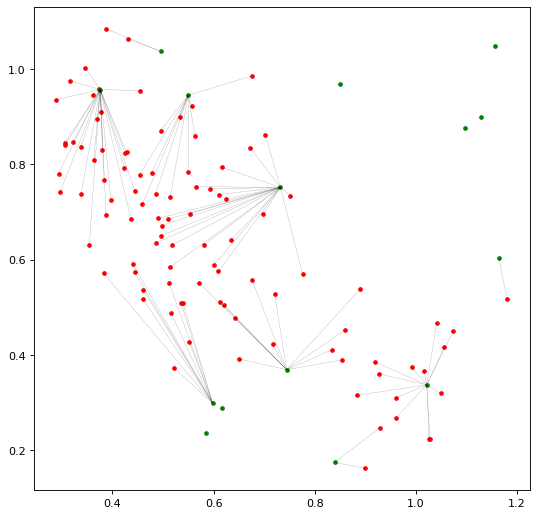

In [343]:
m, x = solve_select_assign(pop, loc, budget, cost=cost)
plot_result(popg=pop, loc=loc, x=x)

## Task 2-2.  Large population
- if population size is very large (100,000 for example), the above approach may take too long computation.
- we can cluster nearby households as a cluster (= village)
    * then treat a cluster as a large household
- how can we make clusters?
    * unsupervised learning
    * k-means clustering algorithm 

### k-means clustering : to group raw data into k clusters
- Input : $P = \{x_p \in R^d; p=0..N-1\}$, k : number of clusters
#### standard algorithm : sklearn.cluster.KMeans
- Initialize means : $\{m_i \in R^d; i=0..k-1\}$
    - randomly select k points from $P$
- repeat 
    * assignment : assign  $x_p \in P$ to the nearest mean $m_i$
        * $S_i = \{x_p; |x_p-m_i| \leq |x_p-m_j| for j=0..k-1 \}$
    * recomputing mean : update $m_i$ as the mean (centroid) of $S_i$
        * $m_i = \frac{1}{|S_i|}\sum_{x_p \in S_i}x_p$
- until no more change in assignment
![image.png](attachment:81d212f5-225d-4f05-8383-7cb3798f919e.png)
(Figures from PRML, Chap.9)

#### minibatch k-means algorithm : sklearn.cluster.MiniBatchKMeans 
* standard K-means algorithm
    - use entire data $P$
    - takes longer when data size is big
* miniBatch k-means algorithm
    - at each iteration, take a random mini-batch (subset) $M \subset P$
    - with $M$, do assignment using $\{m_i\}$ and recomputing mean $\to \{v_i\}$
    - update $m_i \gets (1-\alpha)m_i + \alpha v_i$  ($\alpha$ : learning rate)
    - much faster than standard k-means algo. for large data set, while results are similar

```python
def def cluster_pop(pop, N_popg):
    ...
    return popg, w
```
- complete the above function in the following cell, which
    * takes the following inputs
        - pop : numpy array of household locations, shape=(N,2)
        - N_popg : number of clusters
    * computes clustering using KMeans or MiniBatchKMeans
    * returns 
        * popg : numpy array of cluster centers, shape=(N_popg,2)
        * w : numpy array of cluster sizes, shape=N_popg
- then solve hospital location selection by calling solve_select_assign with popg
- expected output  
![image.png](attachment:c2ea7e97-3fa5-4856-a685-e539ca319dee.png)

In [344]:
# Task 2-2. Fill in this cell
from sklearn.cluster import KMeans, MiniBatchKMeans
def cluster_pop(pop, N_popg):

    N = len(pop)

    pop_df = pd.DataFrame(pop)
    pop_df.columns = ["x", "y"]
    kmeans = KMeans(n_clusters=N_popg)
    kmeans.fit(pop_df)

        
    result = pop_df.copy()
    result["cluster"] = kmeans.labels_
    centroids = result.groupby("cluster").mean()
    popg = np.zeros((N_popg,2))
    w = np.zeros(N_popg)
    for i in range(N):
        c = result["cluster"][i]
        w[c] += 1
    for j in range(N_popg):
            popg[j][0] = centroids['x'][j]
            popg[j][1] = centroids['y'][j]
    

     
    
    return popg, w

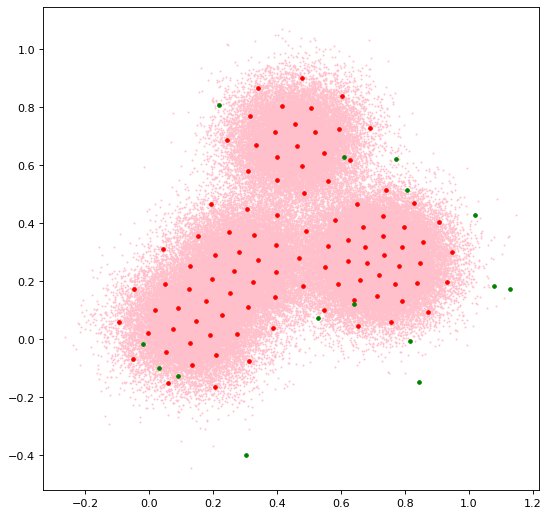

In [345]:
popi = generate_population(100000)
popg, w = cluster_pop(popi, 100)
loc, cost = generate_locations(15, popi)
plot_result(popi=popi, popg=popg, loc=loc)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 101 rows, 1515 columns and 1515 nonzeros
Model fingerprint: 0xd3e94e67
Variable types: 0 continuous, 1515 integer (1515 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Found heuristic solution: objective 65231.570622
Presolve removed 101 rows and 1515 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 18389.4 65231.6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.838936684776e+04, best bound 1.838936684776e+04, gap 0.0000%


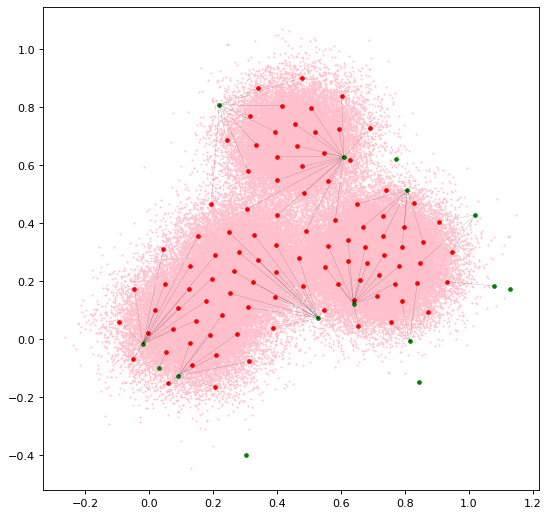

In [346]:
budget = 500
m, x = solve_select_assign(popg, loc, budget, w=w, cost=cost)
plot_result(popi=popi, popg=popg, loc=loc, x=x)